In [4]:
#Classification of MNIST dataset 
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using MLDatasets
using IterTools #Only for plots, not for program

using StatsPlots
using Measures

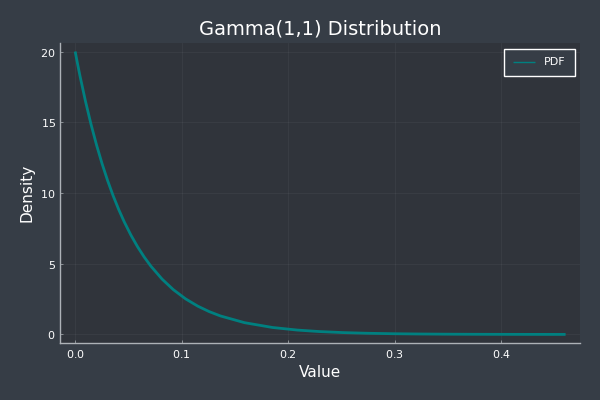

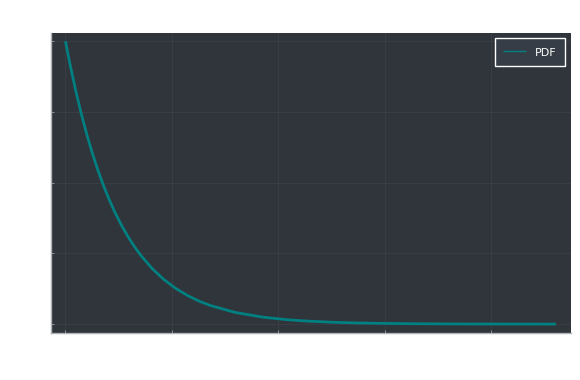

In [21]:
theme(:dark)
pyplot()

a = 1
b = 0.05

num = 100000
x_axis = [1:num]
y_axis = rand(Gamma(a,b),num)

plt = Plots.plot(Gamma(a,b),
    xlabel="Value",
    ylabel="Density",
    title="Gamma(1,1) Distribution",
    label="PDF",
    linewidth=2,
    color=:teal,
    bottom_margin=5mm,
    top_margin=5mm,
    left_margin=5mm,
    right_margin=5mm)
display(plt)

#plt.plot_title("10000 Draws from Gamma(1,1) Distribution")
#plt.xlabel("Value")
#plt.ylabel("Count");

2×2 Array{Float64,2}:
 1.0  0.8
 0.8  1.0

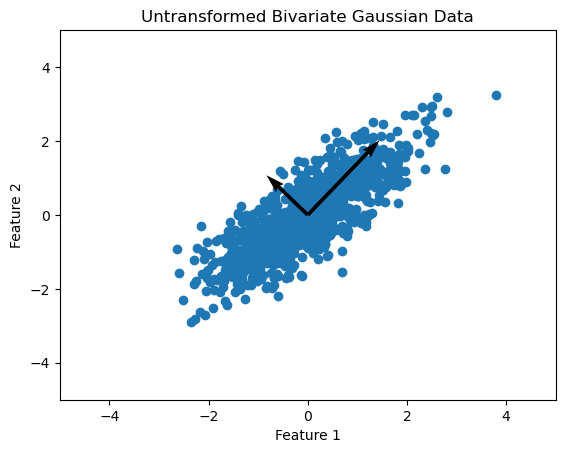

2-element Array{Float64,1}:
 0.19165022316687685
 1.7329114356602768

In [121]:
using PyPlot
μ = [0,0]
Σ = [1 0.8
    0.8 1.0]
display(Σ)
x = rand(MvNormal(μ,Σ),1000)
PyPlot.scatter(x[1,:],x[2,:])
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("Untransformed Bivariate Gaussian Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

dims = 2
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

x2 = cov(transpose(x))
A = eigvecs(x2)
B = eigvals(x2)

PyPlot.quiver(A[2,1],A[2,2],scale=B[1]*25)
PyPlot.quiver(A[1,1],A[1,2],scale=B[2]*5)

B = eigvals(x2)

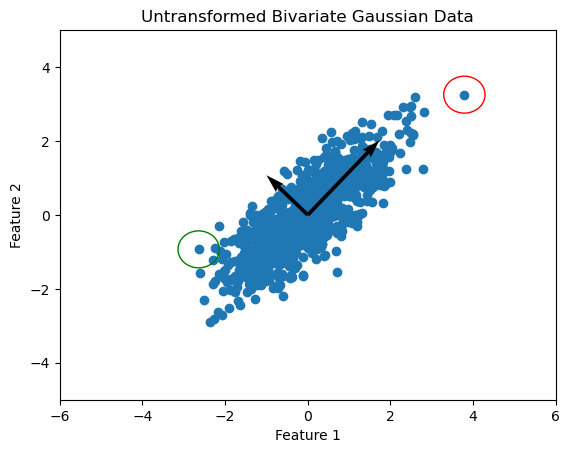

PyObject <matplotlib.patches.Circle object at 0x7f7950848950>

In [157]:
PyPlot.scatter(x[1,:],x[2,:])
plt.xlim(-6,6)
plt.ylim(-5,5)
plt.title("Untransformed Bivariate Gaussian Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

dims = 2
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

x2 = cov(transpose(x))
A = eigvecs(x2)
B = eigvals(x2)

PyPlot.quiver(A[2,1],A[2,2],scale=B[1]*25)
PyPlot.quiver(A[1,1],A[1,2],scale=B[2]*5)

B = eigvals(x2)
plt.gcf().gca().add_artist(plt.Circle((x[:,42]), 0.5, color="red", fill=false))
plt.gcf().gca().add_artist(plt.Circle((x[:,434]), 0.5, color="green", fill=false))

In [149]:
findmin(x[1,:])

(-2.6398168878509836, 434)

In [5]:
cov(transpose(x))

2×2 Array{Float64,2}:
 0.993759  0.612224
 0.612224  2.02172

In [47]:
dims = 2
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

x_pca.prinvars

2-element Array{Float64,1}:
 1.7091884865501215
 0.2056938760535491

In [123]:
cov(x2)

2×2 Array{Float64,2}:
  1.44232e6  -1.93638e6
 -1.93638e6   2.59967e6

In [119]:
x2 = x*transpose(x)
A = eigvecs(x2)
e1 = A[1,2]/A[1,1]
e2 = A[2,2]/A[2,1]

1.0011323032821284

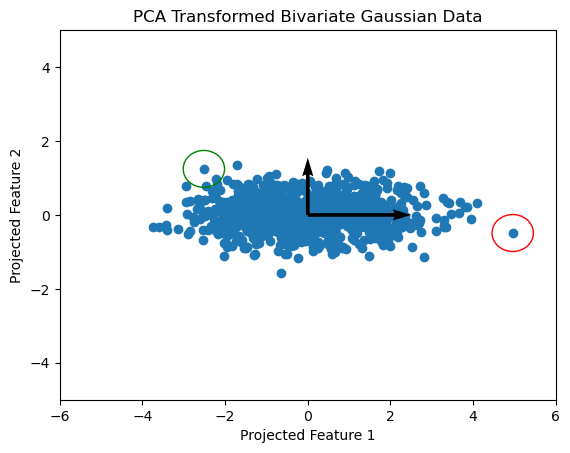

PyObject <matplotlib.patches.Circle object at 0x7f7950982cd0>

In [156]:
PyPlot.scatter(xt[1,:],xt[2,:])
plt.xlim(-6,6)
plt.ylim(-5,5)
plt.title("PCA Transformed Bivariate Gaussian Data")
plt.xlabel("Projected Feature 1")
plt.ylabel("Projected Feature 2")
PyPlot.quiver(1,0,scale=B[1]*25)
PyPlot.quiver(0,1,scale=B[2]*5)
plt.gcf().gca().add_artist(plt.Circle((xt[:,42]), 0.5, color="red", fill=false))
plt.gcf().gca().add_artist(plt.Circle((xt[:,434]), 0.5, color="green", fill=false))

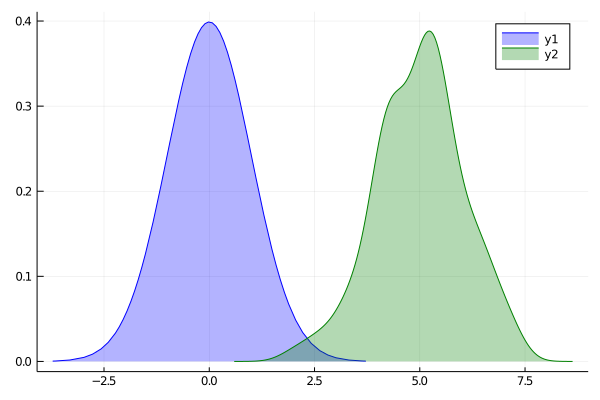

In [134]:
#Bayes Update
num = 100
c = 5
d = 1
likelihood = Normal(c,d)
a = 0
b = 1
prior = Normal(a,b)
x = rand(likelihood,num)
Plots.plot(prior,fillalpha=0.3, fill=(0,:blue), c=:blue)
StatsPlots.density!(x,fillalpha=0.3,fill=(0,:green),c=:green)
#Plots.plot(Normal(5,3))

1.2516323643913039
-331.37758058994274


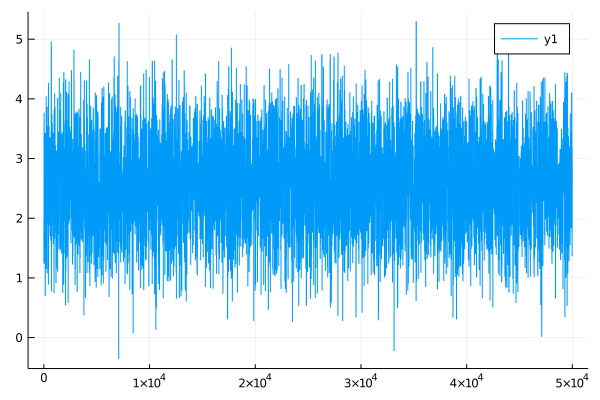

In [135]:
@gen function normal_update()
    μ = @trace(normal(a,b), :μ)
    x = zeros(num)
    for j=1:length(x)
        x[j] = @trace(normal(μ,10), (:x,j))
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(x)
    obs_master[(:x,i)] = x[i]
end
obs = obs_master;
    
(trace,_) = generate(normal_update, (), obs)
println(trace[:μ])
println(get_score(trace))
traces = []
old_trace = trace

for i = 1:50000
    new_μ = old_trace[:μ] + rand(Normal(old_trace[:μ],5.0))
    #println(new_μ)
    obs[:μ] = new_μ
    (new_trace,) = generate(normal_update, (), obs)
    score1 = get_score(old_trace)
    score2 = get_score(new_trace)
    score = score2 - score1
    #println(exp(score))
    if exp(score) >= rand()
        push!(traces,new_trace)
        old_trace = new_trace
    else
        push!(traces,old_trace)
    end
end

Plots.plot([trace[:μ] for trace in traces])

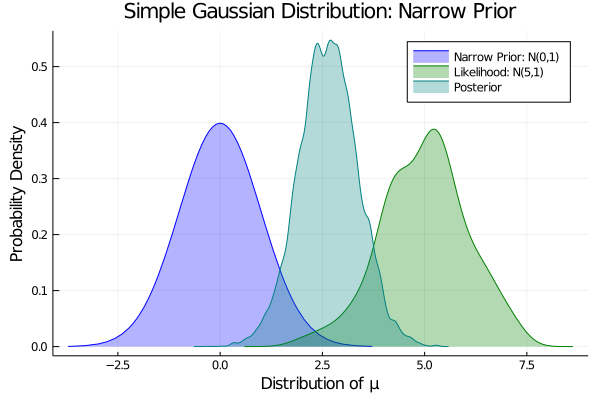

In [136]:
#Bayes Update
StatsPlots.plot(prior,fillalpha=0.3, fill=(0,:blue), c=:blue, label="Narrow Prior: N($a,$b)", 
    xlabel="Distribution of μ",
    ylabel="Probability Density",
    title="Simple Gaussian Distribution: Narrow Prior")
StatsPlots.density!(x,fillalpha=0.3,fill=(0,:green),c=:green, label="Likelihood: N($c,$d)")
StatsPlots.density!([trace[:μ] for trace in traces[10:length(traces)]],fillalpha=0.3,fill=(0,:teal),c=:teal, label="Posterior")

#plt.ylabel("Probability Density")
#plt.xlabel("Distribution of μ")
#plt.title("Bayes Update to Simple Gaussian Distribution")
#Plots.plot(Normal(5,3))

9.184096570293777
-336.644316678675


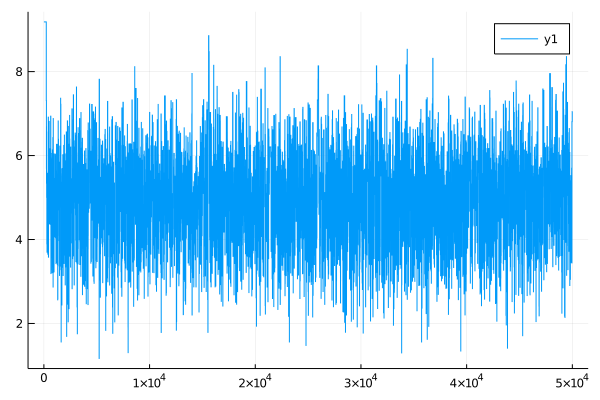

In [137]:
#Bayes Update
num = 100
c = 5
d = 1
likelihood = Normal(c,d)
a = 0
b = 5
prior = Normal(a,b)
x = rand(likelihood,num)
Plots.plot(prior,fillalpha=0.3, fill=(0,:blue), c=:blue)
StatsPlots.density!(x,fillalpha=0.3,fill=(0,:green),c=:green)
#Plots.plot(Normal(5,3))

@gen function normal_update()
    μ = @trace(normal(a,b), :μ)
    x = zeros(num)
    for j=1:length(x)
        x[j] = @trace(normal(μ,10), (:x,j))
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(x)
    obs_master[(:x,i)] = x[i]
end
obs = obs_master;
    
(trace,_) = generate(normal_update, (), obs)
println(trace[:μ])
println(get_score(trace))
traces = []
old_trace = trace

for i = 1:50000
    new_μ = old_trace[:μ] + rand(Normal(old_trace[:μ],5.0))
    #println(new_μ)
    obs[:μ] = new_μ
    (new_trace,) = generate(normal_update, (), obs)
    score1 = get_score(old_trace)
    score2 = get_score(new_trace)
    score = score2 - score1
    #println(exp(score))
    if exp(score) >= rand()
        push!(traces,new_trace)
        old_trace = new_trace
    else
        push!(traces,old_trace)
    end
end

Plots.plot([trace[:μ] for trace in traces])

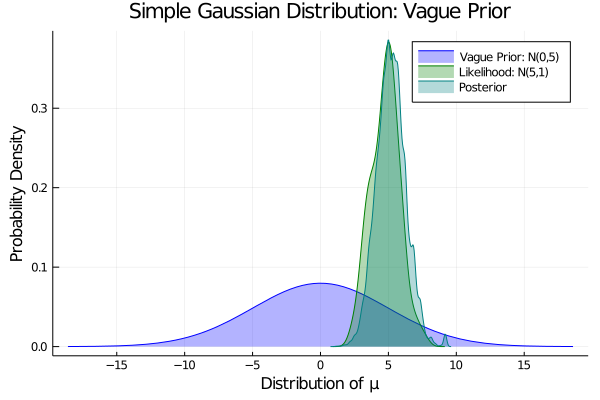

In [138]:
#Bayes Update
StatsPlots.plot(prior,fillalpha=0.3, fill=(0,:blue), c=:blue, label="Vague Prior: N($a,$b)", 
    xlabel="Distribution of μ",
    ylabel="Probability Density",
    title="Simple Gaussian Distribution: Vague Prior")
StatsPlots.density!(x,fillalpha=0.3,fill=(0,:green),c=:green, label="Likelihood: N($c,$d)")
StatsPlots.density!([trace[:μ] for trace in traces[10:length(traces)]],fillalpha=0.3,fill=(0,:teal),c=:teal, label="Posterior")

#plt.ylabel("Probability Density")
#plt.xlabel("Distribution of μ")
#plt.title("Bayes Update to Simple Gaussian Distribution")
#Plots.plot(Normal(5,3))